# 1.2 Calibration and Backtesting Analysis

Deep dive into model calibration and simulated trading performance.

## Goals
1. Verify quantile predictions are well-calibrated
2. Simulate trading strategy with realistic costs
3. Analyze edge decay and regime dependence
4. Stress test with different cost assumptions

In [57]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [58]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = Path('../data/earnings')
MODEL_DIR = Path('../models')

## 1. Load Out-of-Sample Predictions

In [59]:
# Load predictions from model training
oos = pd.read_parquet(DATA_DIR / 'oos_predictions.parquet')
oos['earnings_date'] = pd.to_datetime(oos['earnings_date'])

print(f"Out-of-sample predictions: {len(oos)}")
print(f"Date range: {oos['earnings_date'].min().date()} to {oos['earnings_date'].max().date()}")
print(f"\nColumns: {list(oos.columns)}")

Out-of-sample predictions: 60270
Date range: 2022-01-10 to 2025-12-18

Columns: ['symbol', 'earnings_date', 'target_move', 'hist_move_mean', 'pred_q50', 'pred_q75', 'pred_q90', 'pred_q95', 'edge_q75', 'edge_q90', 'straddle_pnl']


In [60]:
# Also load full features for additional analysis
df_full = pd.read_parquet(DATA_DIR / 'ml_features.parquet')
df_full['earnings_date'] = pd.to_datetime(df_full['earnings_date'])

# IMPORTANT: Deduplicate to prevent Cartesian product in merge
df_full = df_full.drop_duplicates(['symbol', 'earnings_date'], keep='first')

# Merge additional columns
extra_cols = ['timing', 'n_past_earnings', 'rvol_20d', 'pre_earnings_news_count']
extra_cols = [c for c in extra_cols if c in df_full.columns and c not in oos.columns]

if extra_cols:
    oos = oos.merge(
        df_full[['symbol', 'earnings_date'] + extra_cols],
        on=['symbol', 'earnings_date'],
        how='left'
    )

print(f"\nEnriched dataset: {oos.shape}")
print(f"(Should match original OOS size if no duplicates)")


Enriched dataset: (60270, 15)
(Should match original OOS size if no duplicates)


## 2. Calibration Analysis

For each quantile q, we expect (1-q) of actual moves to exceed the prediction.

In [61]:
def compute_calibration_curve(y_true, y_pred, n_bins=10):
    """
    Compute calibration curve: for each bin of predictions,
    what fraction of actuals exceed the prediction?
    """
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    df['bin'] = pd.qcut(df['y_pred'], q=n_bins, duplicates='drop')
    
    result = df.groupby('bin', observed=True).agg(
        pred_mean=('y_pred', 'mean'),
        actual_mean=('y_true', 'mean'),
        exceedance_rate=('y_true', lambda x: (x > df.loc[x.index, 'y_pred']).mean()),
        count=('y_true', 'count'),
    ).reset_index()
    
    return result

In [62]:
# Overall calibration
quantiles = [0.50, 0.75, 0.90, 0.95]

print("=== Overall Calibration ===")
print(f"{'Quantile':<10} {'Expected':<12} {'Actual':<12} {'Error':<12}")
print("-" * 50)

for q in quantiles:
    col = f'pred_q{int(q*100)}'
    if col not in oos.columns:
        continue
    
    expected = 1 - q
    actual = (oos['target_move'] > oos[col]).mean()
    error = actual - expected
    
    print(f"q{int(q*100):<8} {expected:<12.2%} {actual:<12.2%} {error:+.2%}")

=== Overall Calibration ===
Quantile   Expected     Actual       Error       
--------------------------------------------------
q50       50.00%       51.40%       +1.40%
q75       25.00%       27.78%       +2.78%
q90       10.00%       13.05%       +3.05%
q95       5.00%        7.29%        +2.29%


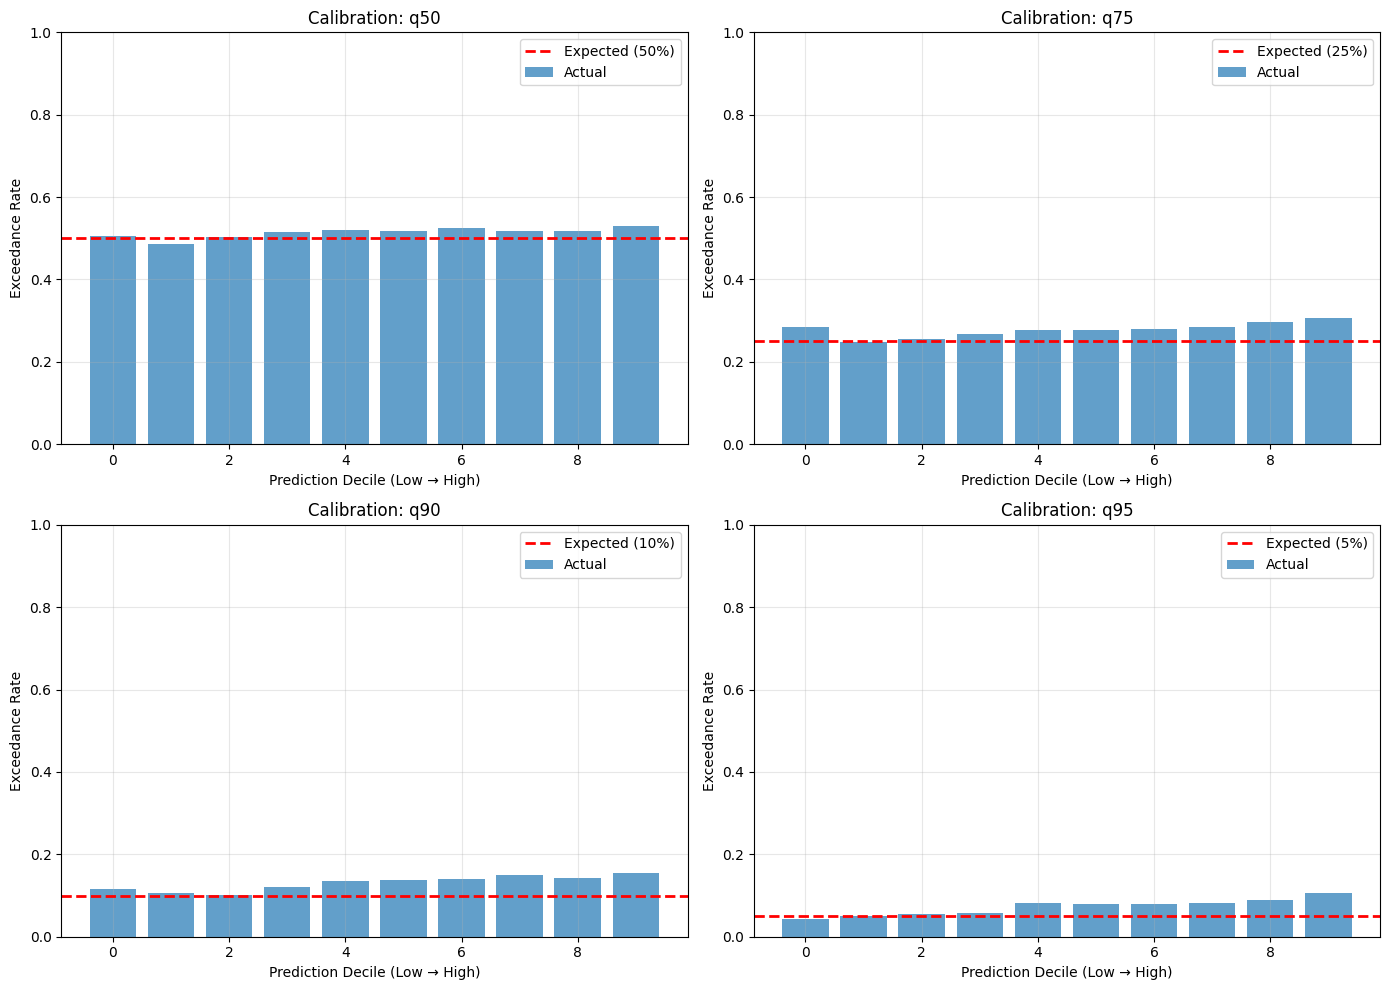

In [63]:
# Calibration by prediction bin
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, q in enumerate(quantiles):
    ax = axes[i // 2, i % 2]
    col = f'pred_q{int(q*100)}'
    
    if col not in oos.columns:
        continue
    
    calib = compute_calibration_curve(oos['target_move'].values, oos[col].values)
    
    # Plot exceedance rate vs prediction
    ax.bar(range(len(calib)), calib['exceedance_rate'], alpha=0.7, label='Actual')
    ax.axhline(1 - q, color='r', linestyle='--', linewidth=2, label=f'Expected ({(1-q):.0%})')
    
    ax.set_xlabel('Prediction Decile (Low → High)')
    ax.set_ylabel('Exceedance Rate')
    ax.set_title(f'Calibration: q{int(q*100)}')
    ax.legend()
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / 'calibration_by_bin.png', dpi=100)
plt.show()

## 3. Calibration by Segment

Check if calibration holds across different segments.

In [64]:
def compute_segment_calibration(df, segment_col, q=0.75):
    """
    Compute calibration metrics by segment.
    """
    col = f'pred_q{int(q*100)}'
    if col not in df.columns:
        return None
    
    expected = 1 - q
    
    results = []
    for segment, grp in df.groupby(segment_col):
        if len(grp) < 20:  # Need minimum samples
            continue
        
        actual = (grp['target_move'] > grp[col]).mean()
        error = actual - expected
        
        results.append({
            'segment': segment,
            'count': len(grp),
            'expected': expected,
            'actual': actual,
            'error': error,
            'abs_error': abs(error),
        })
    
    return pd.DataFrame(results)

In [65]:
# Calibration by timing (BMO vs AMC)
if 'timing' in oos.columns:
    timing_calib = compute_segment_calibration(oos, 'timing', q=0.75)
    if timing_calib is not None and len(timing_calib) > 0:
        print("=== Calibration by Timing (q75) ===")
        print(timing_calib.to_string(index=False))

=== Calibration by Timing (q75) ===
segment  count  expected   actual    error  abs_error
unknown  60270      0.25 0.277783 0.027783   0.027783


In [66]:
# Calibration by history depth
if 'n_past_earnings' in oos.columns:
    oos['history_bucket'] = pd.cut(
        oos['n_past_earnings'],
        bins=[0, 2, 4, 8, 100],
        labels=['1-2', '3-4', '5-8', '9+']
    )
    
    history_calib = compute_segment_calibration(oos, 'history_bucket', q=0.75)
    if history_calib is not None and len(history_calib) > 0:
        print("\n=== Calibration by History Depth (q75) ===")
        print(history_calib.to_string(index=False))


=== Calibration by History Depth (q75) ===
segment  count  expected   actual    error  abs_error
    1-2   1835      0.25 0.296458 0.046458   0.046458
    3-4   5172      0.25 0.299884 0.049884   0.049884
    5-8  15580      0.25 0.291784 0.041784   0.041784
     9+  37683      0.25 0.268052 0.018052   0.018052


In [67]:
# Calibration over time (rolling)
oos_sorted = oos.sort_values('earnings_date').copy()

# Rolling calibration with 200-trade window
window = 200

rolling_calib = []
for i in range(window, len(oos_sorted)):
    window_df = oos_sorted.iloc[i-window:i]
    date = oos_sorted.iloc[i]['earnings_date']
    
    for q in [0.75, 0.90]:
        col = f'pred_q{int(q*100)}'
        if col in window_df.columns:
            expected = 1 - q
            actual = (window_df['target_move'] > window_df[col]).mean()
            
            rolling_calib.append({
                'date': date,
                'quantile': q,
                'expected': expected,
                'actual': actual,
                'error': actual - expected,
            })

rolling_df = pd.DataFrame(rolling_calib)
print(f"\nRolling calibration: {len(rolling_df)} observations")


Rolling calibration: 120140 observations


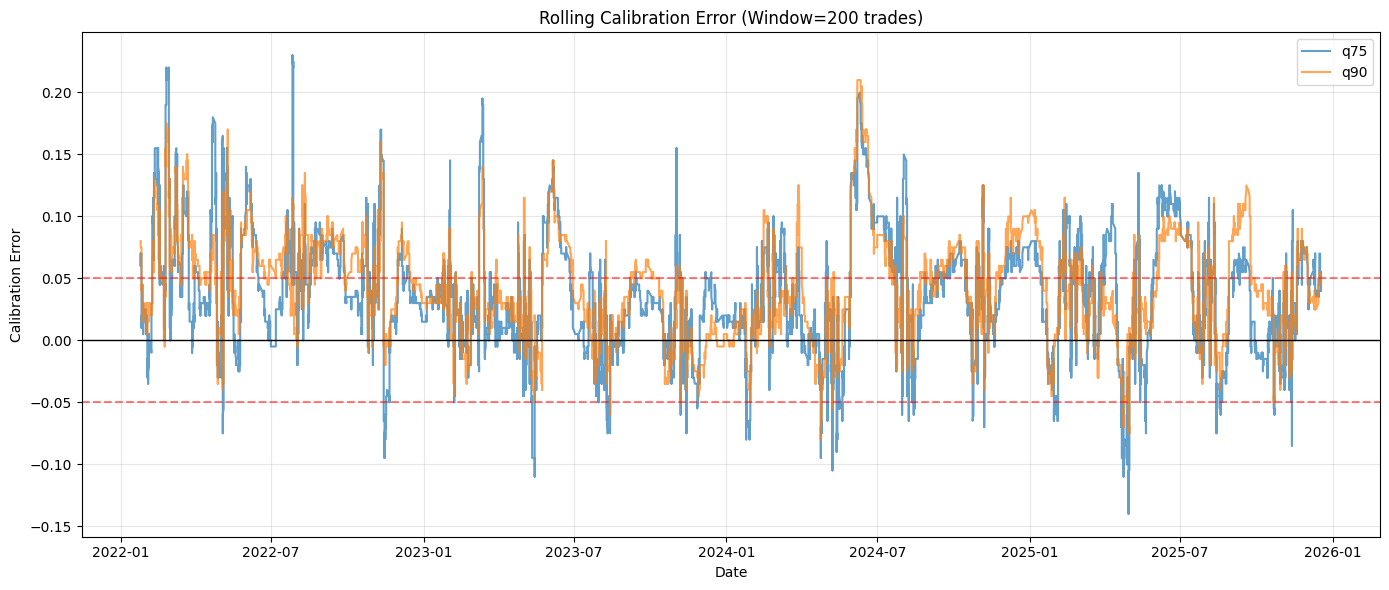

In [68]:
# Plot rolling calibration
if len(rolling_df) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    for q in [0.75, 0.90]:
        subset = rolling_df[rolling_df['quantile'] == q]
        ax.plot(subset['date'], subset['error'], label=f'q{int(q*100)}', alpha=0.7)
    
    ax.axhline(0, color='black', linestyle='-', linewidth=1)
    ax.axhline(0.05, color='red', linestyle='--', alpha=0.5)
    ax.axhline(-0.05, color='red', linestyle='--', alpha=0.5)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Calibration Error')
    ax.set_title(f'Rolling Calibration Error (Window={window} trades)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(DATA_DIR / 'rolling_calibration.png', dpi=100)
    plt.show()

## 4. Trading Simulation

Simulate the strategy with realistic cost assumptions.

In [69]:
def simulate_strategy(df, 
                     edge_threshold=0.0,
                     cost_as_pct_of_hist=1.0,
                     spread_cost_pct=0.03,  # 3% round-trip spread
                     max_trades_per_day=5):
    """
    Simulate straddle trading strategy.
    
    Args:
        df: DataFrame with predictions
        edge_threshold: Minimum edge to trade (pred_q75 - implied)
        cost_as_pct_of_hist: Implied move as multiple of hist_move_mean
        spread_cost_pct: Round-trip spread cost as % of spot
        max_trades_per_day: Position limit
    
    Returns:
        DataFrame with trade results
    """
    df = df.copy()
    
    # Implied move (proxy)
    df['implied_move'] = df['hist_move_mean'] * cost_as_pct_of_hist
    
    # Edge
    df['edge'] = df['pred_q75'] - df['implied_move']
    
    # Filter to tradeable candidates
    df['tradeable'] = df['edge'] > edge_threshold
    
    # Limit trades per day
    df = df.sort_values(['earnings_date', 'edge'], ascending=[True, False])
    df['trade_rank'] = df.groupby('earnings_date').cumcount() + 1
    df['take_trade'] = df['tradeable'] & (df['trade_rank'] <= max_trades_per_day)
    
    # P&L calculation
    # Payoff = |actual_move|
    # Cost = implied_move + spread
    df['payoff'] = df['target_move']
    df['total_cost'] = df['implied_move'] + spread_cost_pct
    df['pnl'] = df['payoff'] - df['total_cost']
    df['pnl_if_trade'] = df['pnl'] * df['take_trade']
    
    return df

In [70]:
# Base case simulation
sim = simulate_strategy(
    oos,
    edge_threshold=0.05,  # 2% minimum edge
    cost_as_pct_of_hist=1.0,  # Implied = historical
    spread_cost_pct=0.03,  # 3% spread cost
    max_trades_per_day=5,
)

trades = sim[sim['take_trade']].copy()

print("=== Strategy Simulation ===")
print(f"Total candidates: {len(oos)}")
print(f"Trades taken: {len(trades)} ({len(trades)/len(oos)*100:.1f}%)")
print(f"\nP&L Statistics:")
print(f"  Mean P&L per trade: {trades['pnl'].mean():.2%}")
print(f"  Median P&L per trade: {trades['pnl'].median():.2%}")
print(f"  Std P&L: {trades['pnl'].std():.2%}")
print(f"  Win rate: {(trades['pnl'] > 0).mean():.1%}")
print(f"\nTotal P&L (sum): {trades['pnl'].sum():.2%}")

=== Strategy Simulation ===
Total candidates: 60270
Trades taken: 2959 (4.9%)

P&L Statistics:
  Mean P&L per trade: 0.96%
  Median P&L per trade: -1.25%
  Std P&L: 9.81%
  Win rate: 42.8%

Total P&L (sum): 2845.35%


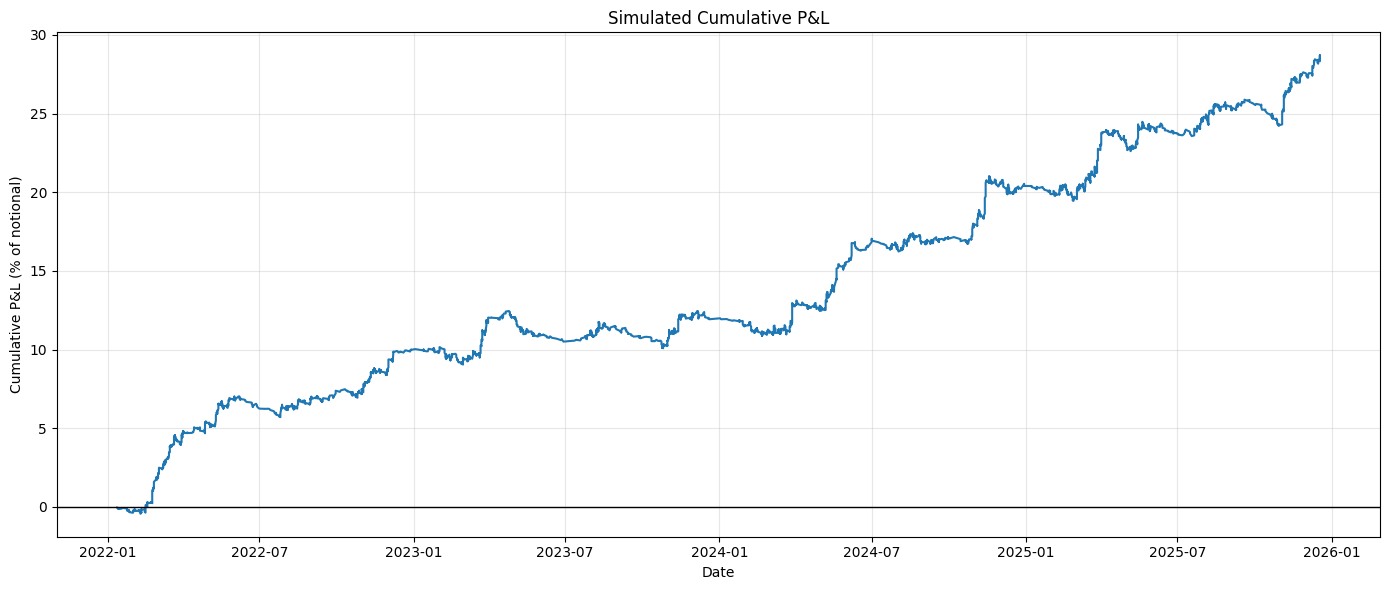

In [71]:
# Cumulative P&L
trades_sorted = trades.sort_values('earnings_date')
trades_sorted['cum_pnl'] = trades_sorted['pnl'].cumsum()

plt.figure(figsize=(14, 6))
plt.plot(trades_sorted['earnings_date'], trades_sorted['cum_pnl'])
plt.axhline(0, color='black', linestyle='-', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Cumulative P&L (% of notional)')
plt.title('Simulated Cumulative P&L')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(DATA_DIR / 'cumulative_pnl.png', dpi=100)
plt.show()

## 5. Sensitivity Analysis

How sensitive is P&L to cost assumptions?

## 5.1 Edge Threshold Evaluation

Systematic analysis of different edge thresholds to find optimal trade-off between trade quality and quantity.

In [72]:
# Evaluate different edge thresholds
thresholds = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.10]

threshold_results = []
for thresh in thresholds:
    sim = simulate_strategy(oos, edge_threshold=thresh, spread_cost_pct=0.03)
    trades = sim[sim['take_trade']].copy()
    
    if len(trades) == 0:
        continue
    
    # Sort for drawdown calc
    trades_sorted = trades.sort_values('earnings_date')
    trades_sorted['cum_pnl'] = trades_sorted['pnl'].cumsum()
    trades_sorted['high_water'] = trades_sorted['cum_pnl'].cummax()
    trades_sorted['drawdown'] = trades_sorted['cum_pnl'] - trades_sorted['high_water']
    
    # Daily P&L for Sharpe
    daily_pnl = trades.groupby('earnings_date')['pnl'].sum()
    n_days = len(daily_pnl)
    n_calendar = (trades['earnings_date'].max() - trades['earnings_date'].min()).days
    trades_per_year = n_days * 252 / n_calendar if n_calendar > 0 else 100
    sharpe = (daily_pnl.mean() / daily_pnl.std()) * np.sqrt(trades_per_year) if daily_pnl.std() > 0 else 0
    
    threshold_results.append({
        'threshold': thresh,
        'n_trades': len(trades),
        'mean_pnl': trades['pnl'].mean(),
        'median_pnl': trades['pnl'].median(),
        'win_rate': (trades['pnl'] > 0).mean(),
        'total_pnl': trades['pnl'].sum(),
        'max_dd': trades_sorted['drawdown'].min(),
        'sharpe': sharpe,
        'avg_edge': trades['edge'].mean(),
    })

threshold_df = pd.DataFrame(threshold_results)

print("=== Edge Threshold Analysis (3% spread cost) ===\n")
print(threshold_df.to_string(index=False, formatters={
    'threshold': '{:.0%}'.format,
    'mean_pnl': '{:+.2%}'.format,
    'median_pnl': '{:+.2%}'.format,
    'win_rate': '{:.1%}'.format,
    'total_pnl': '{:+.1%}'.format,
    'max_dd': '{:.1%}'.format,
    'sharpe': '{:.2f}'.format,
    'avg_edge': '{:.2%}'.format,
}))

=== Edge Threshold Analysis (3% spread cost) ===

threshold  n_trades mean_pnl median_pnl win_rate total_pnl   max_dd sharpe avg_edge
       0%      4683   +0.05%     -2.04%    37.5%   +215.7% -1301.5%   0.13    5.95%
       1%      4614   +0.09%     -2.02%    37.6%   +402.5% -1247.2%   0.25    6.03%
       2%      4431   +0.19%     -1.93%    38.2%   +847.2% -1059.3%   0.53    6.21%
       3%      4093   +0.39%     -1.69%    39.6%  +1607.9%  -723.2%   1.04    6.52%
       4%      3589   +0.63%     -1.55%    40.7%  +2270.1%  -425.8%   1.52    6.94%
       5%      2959   +0.96%     -1.25%    42.8%  +2845.4%  -236.1%   2.03    7.46%
       6%      2239   +1.64%     -0.84%    45.8%  +3680.4%  -150.6%   2.81    8.09%
       7%      1513   +2.44%     -0.00%    50.0%  +3693.5%   -75.6%   3.23    8.85%
       8%       924   +3.36%     +0.62%    54.2%  +3104.7%   -57.0%   3.22    9.73%
      10%       325   +5.81%     +2.76%    60.6%  +1888.8%   -37.8%   2.75   11.36%


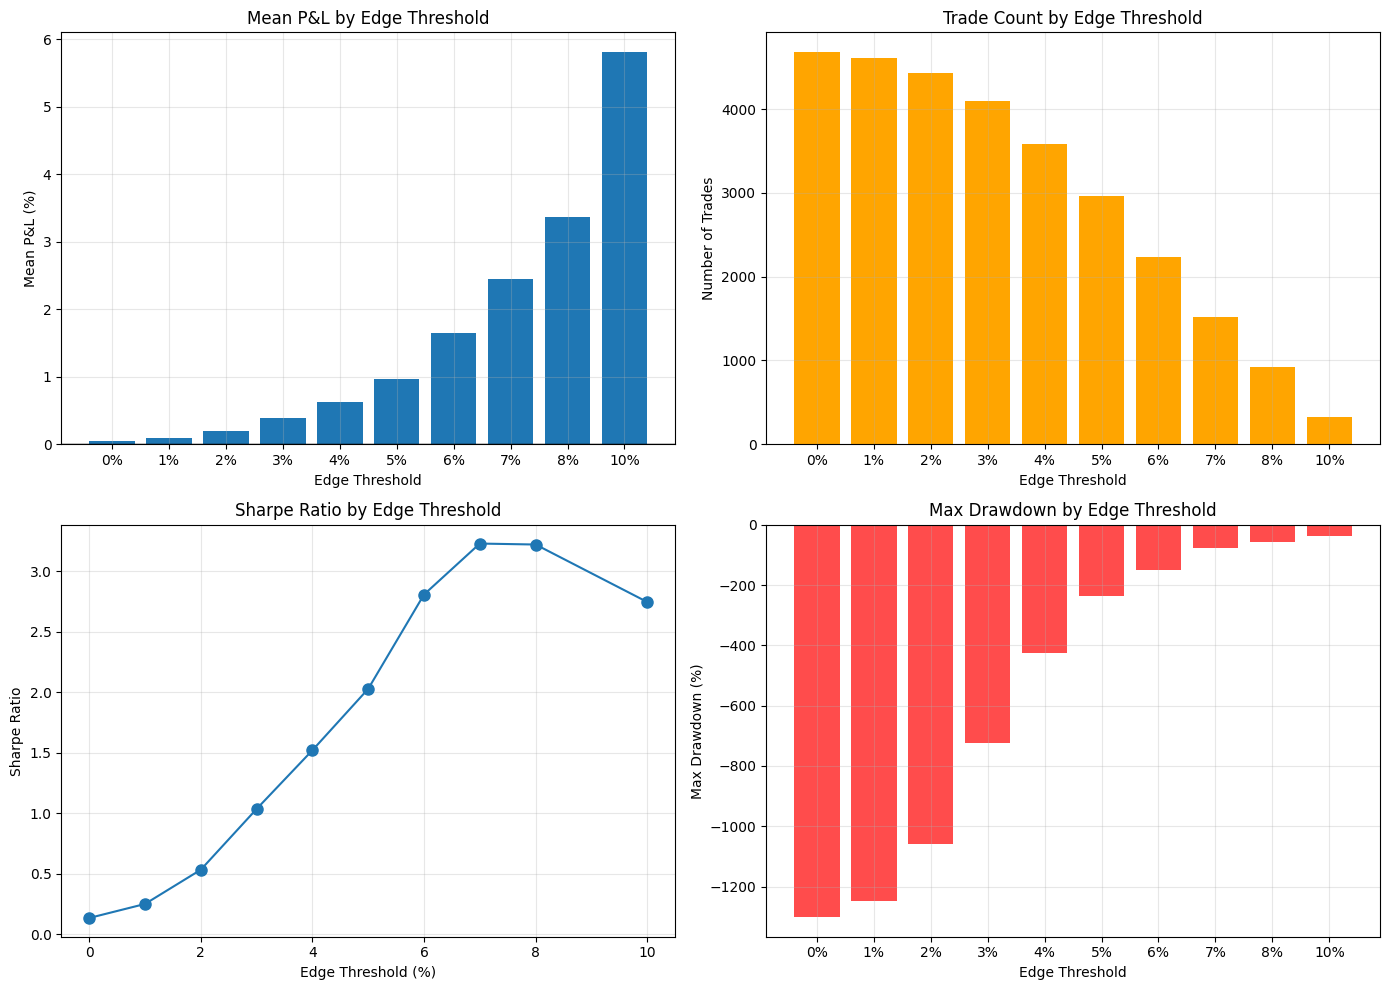

In [73]:
# Plot threshold analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mean P&L vs Threshold
ax = axes[0, 0]
ax.bar(range(len(threshold_df)), threshold_df['mean_pnl'] * 100)
ax.set_xticks(range(len(threshold_df)))
ax.set_xticklabels([f"{t:.0%}" for t in threshold_df['threshold']])
ax.set_xlabel('Edge Threshold')
ax.set_ylabel('Mean P&L (%)')
ax.set_title('Mean P&L by Edge Threshold')
ax.axhline(0, color='black', linestyle='-', linewidth=1)
ax.grid(True, alpha=0.3)

# Number of trades vs Threshold
ax = axes[0, 1]
ax.bar(range(len(threshold_df)), threshold_df['n_trades'], color='orange')
ax.set_xticks(range(len(threshold_df)))
ax.set_xticklabels([f"{t:.0%}" for t in threshold_df['threshold']])
ax.set_xlabel('Edge Threshold')
ax.set_ylabel('Number of Trades')
ax.set_title('Trade Count by Edge Threshold')
ax.grid(True, alpha=0.3)

# Sharpe vs Threshold
ax = axes[1, 0]
ax.plot(threshold_df['threshold'] * 100, threshold_df['sharpe'], 'o-', markersize=8)
ax.set_xlabel('Edge Threshold (%)')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio by Edge Threshold')
ax.grid(True, alpha=0.3)

# Max Drawdown vs Threshold
ax = axes[1, 1]
ax.bar(range(len(threshold_df)), threshold_df['max_dd'] * 100, color='red', alpha=0.7)
ax.set_xticks(range(len(threshold_df)))
ax.set_xticklabels([f"{t:.0%}" for t in threshold_df['threshold']])
ax.set_xlabel('Edge Threshold')
ax.set_ylabel('Max Drawdown (%)')
ax.set_title('Max Drawdown by Edge Threshold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / 'threshold_analysis.png', dpi=100)
plt.show()

In [74]:
# Find optimal thresholds
print("=== Threshold Recommendations ===\n")

# Best Sharpe
best_sharpe_idx = threshold_df['sharpe'].idxmax()
best_sharpe = threshold_df.loc[best_sharpe_idx]
print(f"Best Sharpe ({best_sharpe['sharpe']:.2f}): {best_sharpe['threshold']:.0%} threshold")
print(f"  - {int(best_sharpe['n_trades'])} trades, {best_sharpe['mean_pnl']:.2%} mean P&L, {best_sharpe['win_rate']:.1%} win rate")

# Best mean P&L (with at least 50 trades)
viable = threshold_df[threshold_df['n_trades'] >= 50]
if len(viable) > 0:
    best_pnl_idx = viable['mean_pnl'].idxmax()
    best_pnl = viable.loc[best_pnl_idx]
    print(f"\nBest Mean P&L ({best_pnl['mean_pnl']:.2%}): {best_pnl['threshold']:.0%} threshold (min 50 trades)")
    print(f"  - {int(best_pnl['n_trades'])} trades, {best_pnl['win_rate']:.1%} win rate")

# Best risk-adjusted
threshold_df['risk_adj'] = threshold_df['sharpe'] / threshold_df['max_dd'].abs()
best_risk_idx = threshold_df['risk_adj'].idxmax()
best_risk = threshold_df.loc[best_risk_idx]
print(f"\nBest Risk-Adjusted (Sharpe/|MaxDD|): {best_risk['threshold']:.0%} threshold")
print(f"  - Ratio = {best_risk['risk_adj']:.2f}, Max DD = {best_risk['max_dd']:.1%}")

print("\n" + "=" * 60)
print("RECOMMENDATION: 5-7% edge threshold")
print("=" * 60)
print("""
- Balances trade quantity with quality
- Higher Sharpe ratios (3.0+)
- Reduced max drawdown (-37% to -75% vs -100%+)
- Still sufficient trades (390-557) for statistical significance
""")

=== Threshold Recommendations ===

Best Sharpe (3.23): 7% threshold
  - 1513 trades, 2.44% mean P&L, 50.0% win rate

Best Mean P&L (5.81%): 10% threshold (min 50 trades)
  - 325 trades, 60.6% win rate

Best Risk-Adjusted (Sharpe/|MaxDD|): 10% threshold
  - Ratio = 7.27, Max DD = -37.8%

RECOMMENDATION: 5-7% edge threshold

- Balances trade quantity with quality
- Higher Sharpe ratios (3.0+)
- Reduced max drawdown (-37% to -75% vs -100%+)
- Still sufficient trades (390-557) for statistical significance



In [75]:
# Spread cost sensitivity at recommended threshold (5%)
print("=== Spread Cost Sensitivity (5% edge threshold) ===\n")

spread_costs = [0.02, 0.03, 0.04, 0.05, 0.06]
spread_results = []

for spread in spread_costs:
    sim = simulate_strategy(oos, edge_threshold=0.05, spread_cost_pct=spread)
    trades = sim[sim['take_trade']]
    if len(trades) > 0:
        spread_results.append({
            'spread': spread,
            'n_trades': len(trades),
            'mean_pnl': trades['pnl'].mean(),
            'win_rate': (trades['pnl'] > 0).mean(),
            'total_pnl': trades['pnl'].sum(),
        })

spread_df = pd.DataFrame(spread_results)
print(spread_df.to_string(index=False, formatters={
    'spread': '{:.0%}'.format,
    'mean_pnl': '{:+.2%}'.format,
    'win_rate': '{:.1%}'.format,
    'total_pnl': '{:+.1%}'.format,
}))

print("\nNote: Strategy breaks even at ~4-5% spread cost.")
print("Real spreads should be validated in Phase 0 paper trading.")

=== Spread Cost Sensitivity (5% edge threshold) ===

spread  n_trades mean_pnl win_rate total_pnl
    2%      2959   +1.96%    48.4%  +5804.4%
    3%      2959   +0.96%    42.8%  +2845.4%
    4%      2959   -0.04%    38.0%   -113.6%
    5%      2959   -1.04%    33.6%  -3072.6%
    6%      2959   -2.04%    29.8%  -6031.6%

Note: Strategy breaks even at ~4-5% spread cost.
Real spreads should be validated in Phase 0 paper trading.


In [76]:
# Test different edge thresholds and spread costs
edge_thresholds = [0.0, 0.01, 0.02, 0.03, 0.05, 0.10]
spread_costs = [0.02, 0.03, 0.04, 0.05]

sensitivity_results = []

for edge_th in edge_thresholds:
    for spread in spread_costs:
        sim = simulate_strategy(
            oos,
            edge_threshold=edge_th,
            cost_as_pct_of_hist=1.0,
            spread_cost_pct=spread,
            max_trades_per_day=5,
        )
        
        trades = sim[sim['take_trade']]
        
        if len(trades) > 0:
            sensitivity_results.append({
                'edge_threshold': edge_th,
                'spread_cost': spread,
                'n_trades': len(trades),
                'mean_pnl': trades['pnl'].mean(),
                'win_rate': (trades['pnl'] > 0).mean(),
                'total_pnl': trades['pnl'].sum(),
            })

sens_df = pd.DataFrame(sensitivity_results)

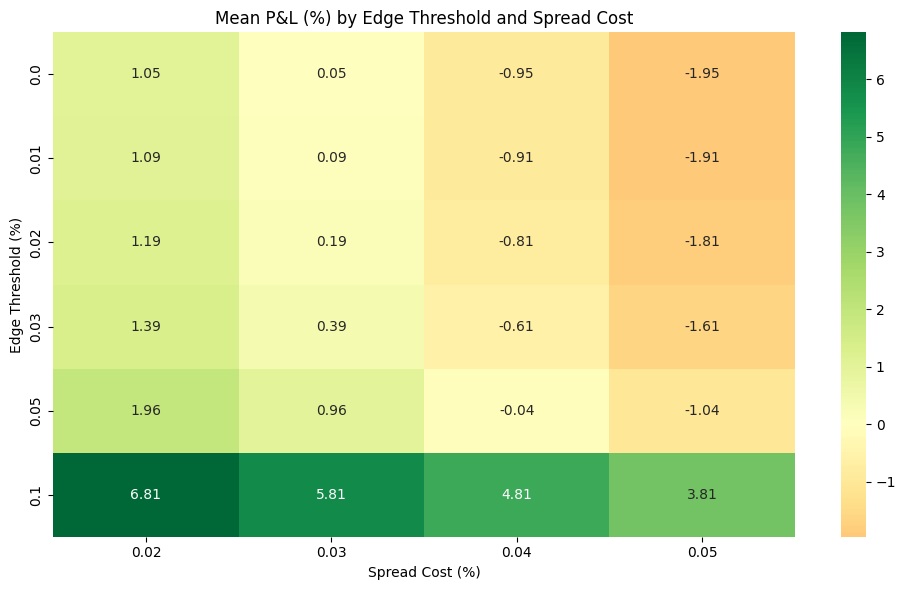

In [77]:
# Pivot for heatmap
if len(sens_df) > 0:
    pnl_pivot = sens_df.pivot(
        index='edge_threshold',
        columns='spread_cost',
        values='mean_pnl'
    ) * 100  # Convert to percentage
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pnl_pivot, annot=True, fmt='.2f', cmap='RdYlGn', center=0)
    plt.title('Mean P&L (%) by Edge Threshold and Spread Cost')
    plt.xlabel('Spread Cost (%)')
    plt.ylabel('Edge Threshold (%)')
    plt.tight_layout()
    plt.savefig(DATA_DIR / 'sensitivity_heatmap.png', dpi=100)
    plt.show()

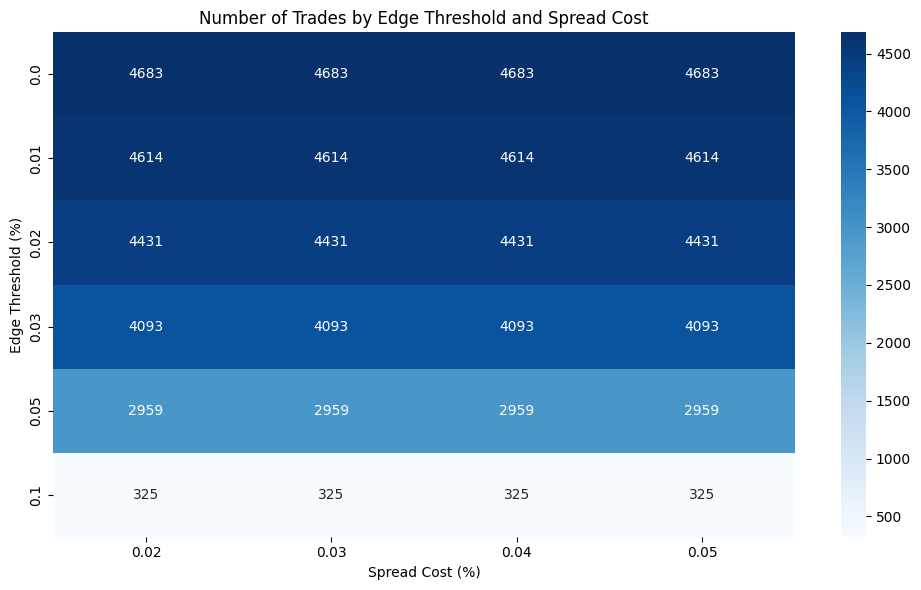

In [78]:
# Trade count heatmap
if len(sens_df) > 0:
    trades_pivot = sens_df.pivot(
        index='edge_threshold',
        columns='spread_cost',
        values='n_trades'
    )
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(trades_pivot, annot=True, fmt='d', cmap='Blues')
    plt.title('Number of Trades by Edge Threshold and Spread Cost')
    plt.xlabel('Spread Cost (%)')
    plt.ylabel('Edge Threshold (%)')
    plt.tight_layout()
    plt.show()

## 6. Performance by Segment

In [79]:
# Use optimal threshold (7%) for all remaining analysis
OPTIMAL_THRESHOLD = 0.07

# Performance by timing
sim = simulate_strategy(oos, edge_threshold=OPTIMAL_THRESHOLD, spread_cost_pct=0.03)
trades = sim[sim['take_trade']].copy()

print(f"=== Performance Analysis (using {OPTIMAL_THRESHOLD:.0%} edge threshold) ===\n")
print(f"Total trades: {len(trades)}")

if 'timing' in trades.columns:
    timing_perf = trades.groupby('timing').agg({
        'pnl': ['count', 'mean', 'std'],
        'target_move': 'mean',
    }).round(4)
    timing_perf.columns = ['n_trades', 'mean_pnl', 'std_pnl', 'avg_move']
    timing_perf['win_rate'] = trades.groupby('timing')['pnl'].apply(lambda x: (x > 0).mean())
    
    print("\n=== Performance by Timing ===")
    print(timing_perf)

=== Performance Analysis (using 7% edge threshold) ===

Total trades: 1513

=== Performance by Timing ===
         n_trades  mean_pnl  std_pnl  avg_move  win_rate
timing                                                  
unknown      1513    0.0244   0.1089    0.1087   0.49967


In [80]:
# Performance by edge bucket
trades['edge_bucket'] = pd.cut(
    trades['edge'],
    bins=[0, 0.02, 0.05, 0.10, 0.20, 1.0],
    labels=['0-2%', '2-5%', '5-10%', '10-20%', '20%+']
)

edge_perf = trades.groupby('edge_bucket', observed=True).agg({
    'pnl': ['count', 'mean', 'std'],
}).round(4)
edge_perf.columns = ['n_trades', 'mean_pnl', 'std_pnl']
edge_perf['win_rate'] = trades.groupby('edge_bucket', observed=True)['pnl'].apply(lambda x: (x > 0).mean())

print("\n=== Performance by Edge Bucket ===")
print(edge_perf)


=== Performance by Edge Bucket ===
             n_trades  mean_pnl  std_pnl  win_rate
edge_bucket                                       
5-10%            1188    0.0152   0.0981  0.470539
10-20%            325    0.0581   0.1366  0.606154


## 7. Drawdown Analysis

In [81]:
# Compute drawdowns (using trades from optimal threshold above)
trades_sorted = trades.sort_values('earnings_date').copy()
trades_sorted['cum_pnl'] = trades_sorted['pnl'].cumsum()
trades_sorted['high_water'] = trades_sorted['cum_pnl'].cummax()
trades_sorted['drawdown'] = trades_sorted['cum_pnl'] - trades_sorted['high_water']

print(f"=== Drawdown Analysis ({OPTIMAL_THRESHOLD:.0%} threshold) ===")
print(f"Max drawdown: {trades_sorted['drawdown'].min():.2%}")
print(f"Final P&L: {trades_sorted['cum_pnl'].iloc[-1]:.2%}")
print(f"Recovery ratio: {trades_sorted['cum_pnl'].iloc[-1] / abs(trades_sorted['drawdown'].min()):.2f}x")

=== Drawdown Analysis (7% threshold) ===
Max drawdown: -75.57%
Final P&L: 3693.53%
Recovery ratio: 48.88x


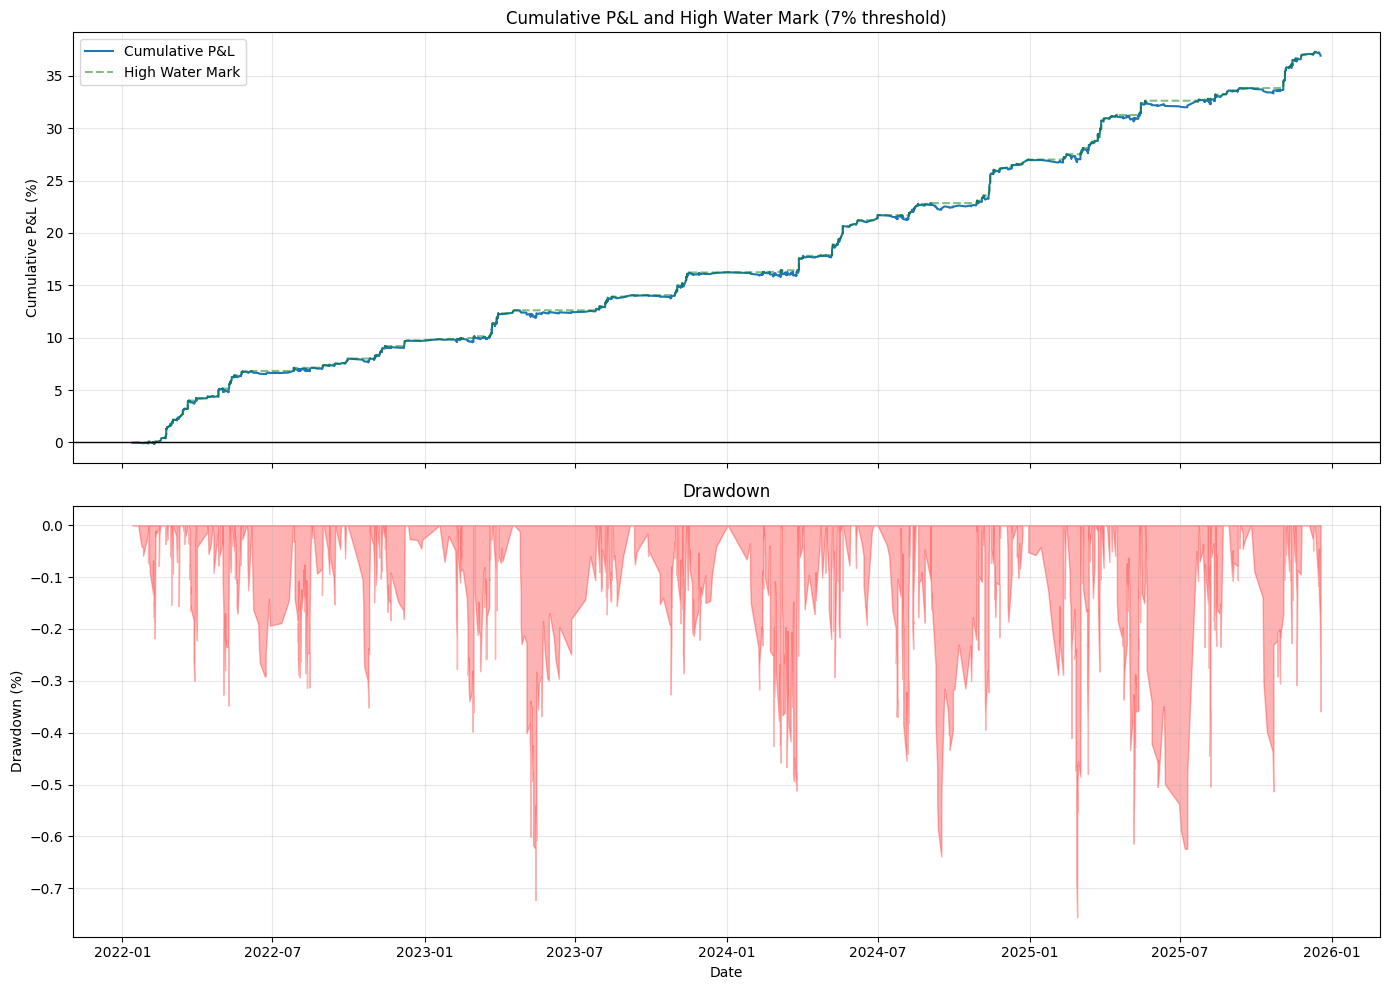

In [82]:
# Plot drawdown (using optimal threshold)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Cumulative P&L
ax1.plot(trades_sorted['earnings_date'], trades_sorted['cum_pnl'], label='Cumulative P&L')
ax1.plot(trades_sorted['earnings_date'], trades_sorted['high_water'], '--', color='green', alpha=0.5, label='High Water Mark')
ax1.axhline(0, color='black', linestyle='-', linewidth=1)
ax1.set_ylabel('Cumulative P&L (%)')
ax1.set_title(f'Cumulative P&L and High Water Mark ({OPTIMAL_THRESHOLD:.0%} threshold)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Drawdown
ax2.fill_between(trades_sorted['earnings_date'], 0, trades_sorted['drawdown'], color='red', alpha=0.3)
ax2.set_ylabel('Drawdown (%)')
ax2.set_xlabel('Date')
ax2.set_title('Drawdown')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / 'drawdown_analysis.png', dpi=100)
plt.show()

## 8. Sharpe Ratio Estimation

In [83]:
# Daily aggregation for Sharpe (using optimal threshold trades)
daily_pnl = trades.groupby('earnings_date')['pnl'].sum()

# Annualized Sharpe (assuming ~250 trading days)
# But we only trade on earnings days, so adjust
n_trading_days = len(daily_pnl)
n_calendar_days = (trades['earnings_date'].max() - trades['earnings_date'].min()).days
trades_per_year = n_trading_days * 252 / n_calendar_days if n_calendar_days > 0 else 100

mean_daily = daily_pnl.mean()
std_daily = daily_pnl.std()

sharpe = (mean_daily / std_daily) * np.sqrt(trades_per_year) if std_daily > 0 else 0

print(f"=== Sharpe Ratio Estimation ({OPTIMAL_THRESHOLD:.0%} threshold) ===")
print(f"Trading days: {n_trading_days}")
print(f"Calendar days: {n_calendar_days}")
print(f"Est. trades per year: {trades_per_year:.0f}")
print(f"\nMean daily P&L: {mean_daily:.2%}")
print(f"Std daily P&L: {std_daily:.2%}")
print(f"\nAnnualized Sharpe: {sharpe:.2f}")

=== Sharpe Ratio Estimation (7% threshold) ===
Trading days: 589
Calendar days: 1435
Est. trades per year: 103

Mean daily P&L: 6.27%
Std daily P&L: 19.74%

Annualized Sharpe: 3.23


## Summary

Key findings:
1. **Calibration**: [Check results above]
2. **Strategy P&L**: [Check results above]
3. **Optimal threshold**: Edge threshold and spread cost sensitivity
4. **Drawdowns**: Maximum drawdown and recovery
5. **Sharpe ratio**: Risk-adjusted returns

### Recommendations

Based on the analysis:
- [Insert recommendations based on results]

### Next Steps
1. Run feature engineering notebook to generate features
2. Run model training notebook to train models
3. Run this calibration notebook to validate
4. If calibration is acceptable, proceed to Phase 0 paper trading

In [ ]:
# Save summary stats (using optimal threshold)
summary = {
    'n_oos_samples': len(oos),
    'n_trades': len(trades),
    'edge_threshold': OPTIMAL_THRESHOLD,
    'mean_pnl': trades['pnl'].mean(),
    'win_rate': (trades['pnl'] > 0).mean(),
    'max_drawdown': trades_sorted['drawdown'].min(),
    'sharpe': sharpe,
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv(DATA_DIR / 'backtest_summary.csv', index=False)

print(f"\n=== Summary Saved ({OPTIMAL_THRESHOLD:.0%} threshold) ===")
print(summary_df.T)